For this project, I used the CICIDS2017 dataset introduced by Sharafaldin. He created this dataset because he thought other IDS datasets were not good enough. The goal of this project was to replicate a big part of their paper which was to build an effective machine learning model to detect cyberattacks. I downloaded the dataset and decided to use the logs from one day. This file contained both benign and DDoS traffic. I cleaned the data and trained 2 models (Random Forest and Logistic Regression) to see if the network traffic was either malicious or normal. I try to improve the performance, I applied SMOTE and RFE (Recursive Feature Elimination) to select the best features. I analyzed the models using accuracy and F1 scores which showed very strong performance in detecting attacks. Overall, this project showed that CICIDS2017 is a valuable dataset for training IDS's and applying

Citation:
Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani, “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”, 4th International Conference on Information Systems Security and Privacy (ICISSP), Portugal, January 2018.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

I loaded the Friday-WorkingHours-Afternoon dataset which was downloaded as a csv file. These files were raw PCAP traffic captures and had necessary features for machine learning. I decided to only do one day because all of these files were very large and would take a long time to process, I instead decided to take a sample of the whole dataset.

In [ ]:
#Load the Dataset
df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
print("Shape:", df.shape)
df.head()
df.columns = df.columns.str.strip()

Shape: (225745, 79)


Next, I had to clean the data to prepare it for the tests. I had to get rid of all of the blank values as well as convert the label column to binary where 0=Benign and 1=Attack. I also used SMOTE to help with any imbalances between the classes along with feature scaling. All of this made sure the data was ready to model.

In [ ]:
#Clean the Data
df.dropna(axis=1, how='all', inplace=True)
df.dropna(inplace=True)

# Convert label column to binary: 0 = BENIGN, 1 = attack
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

print("Label Counts:\n", df['Label'].value_counts())

Label Counts:
 Label
1    128027
0     97714
Name: count, dtype: int64


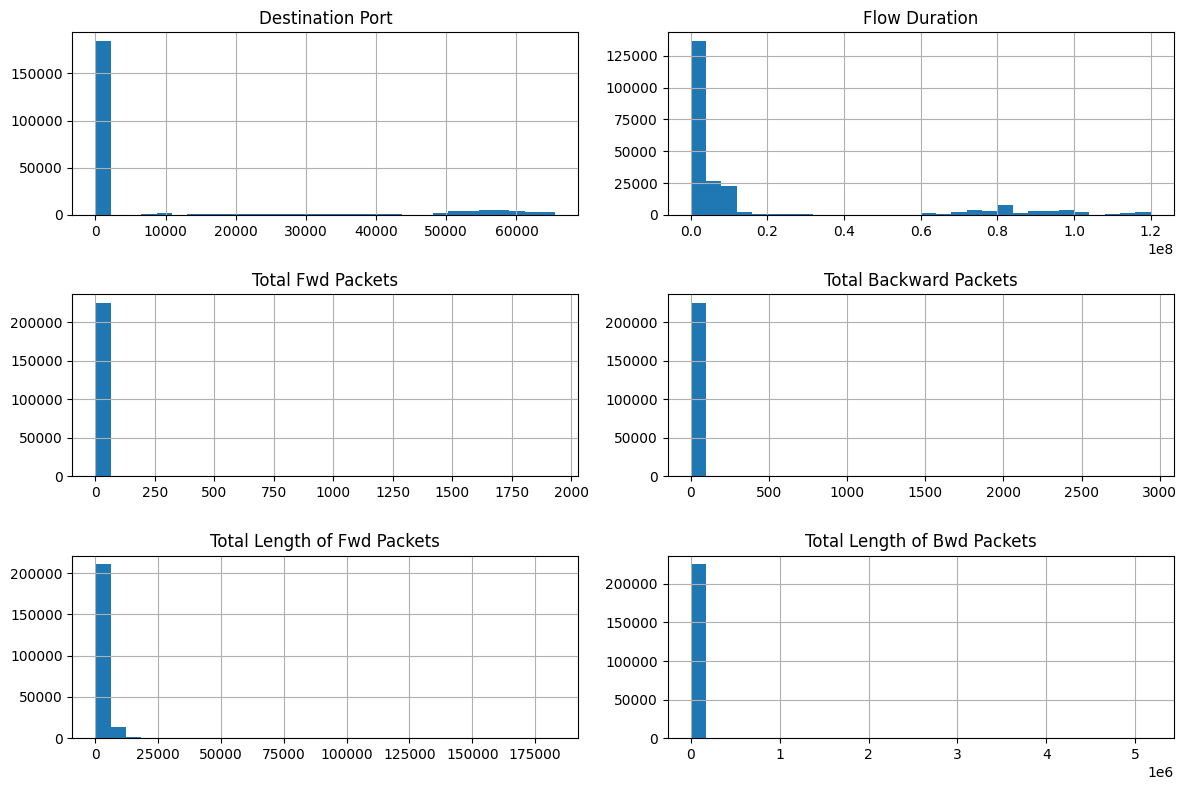

In [ ]:
#Data Analysis Depicted in Graphs
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols[:6]].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

Next was feature selection. There were many features in this dataset that were not useful at all for these predictions so I did not include them. I used Recursive Feature Elimintation and tree-based model feature importances to get rid of irrelevant features.

In [ ]:
#Prepare Features and Target
X = df.drop('Label', axis=1)
y = df['Label']

In [ ]:
#Cleaning Up Data and Fixing Errors
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print("Any NaNs left?", df.isnull().values.any())

X = df.drop('Label', axis=1)
y = df['Label']

Any NaNs left? False


In [ ]:
#Balance the Data with SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

print("Resampled class distribution:\n", pd.Series(y_resampled).value_counts())

Resampled class distribution:
 Label
0    128025
1    128025
Name: count, dtype: int64


In [ ]:
#Feature Selection with RFE (using Logistic Regression)
rfe_selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=10)
X_rfe = rfe_selector.fit_transform(X_resampled, y_resampled)

selected_features = X.columns[rfe_selector.get_support()]
print("Selected features:\n", selected_features)

Selected features:
 Index(['Fwd Packet Length Std', 'Bwd Packet Length Min',
       'Bwd Packet Length Std', 'Fwd Header Length', 'Bwd Header Length',
       'Min Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Fwd Header Length.1', 'Subflow Fwd Bytes'],
      dtype='object')


In [ ]:
#Train-Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y_resampled, test_size=0.3, random_state=42)

During this step in the project, I decided to use the Random Forest, Logistic Regression model, K-Nearest Neighbors, Support Vector Machine, Decision Tree, and Gradient Boosting. These models are trained on the data from the step above and evaluated on the test set. The metrics that I had the models output were precision, recall, f1 score, and support. This helps us understand how well each model distinguishes between the normal traffic and malicious traffic. The reason I did not decide to add more models is because I did not think it was necessary since the part of the paper that I was focusing on was showing that it was infact a very good IDS dataset.

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test, preds))



=== Random Forest ===
Accuracy: 0.9993
Precision: 1.0000
Recall: 0.9986
F1 Score: 0.9993
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38264
           1       1.00      1.00      1.00     38551

    accuracy                           1.00     76815
   macro avg       1.00      1.00      1.00     76815
weighted avg       1.00      1.00      1.00     76815


=== Logistic Regression ===
Accuracy: 0.9871
Precision: 0.9768
Recall: 0.9981
F1 Score: 0.9873
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     38264
           1       0.98      1.00      0.99     38551

    accuracy                           0.99     76815
   macro avg       0.99      0.99      0.99     76815
weighted avg       0.99      0.99      0.99     76815


=== K-Nearest Neighbors ===
Accuracy: 0.9992
Precision: 0.9998
Recall: 0.9986
F1 Score: 0.9992
Classification R

For this project, I used the CICIDS2017 dataset introduced by Sharafaldin. He created this dataset because he thought other IDS datasets were not good enough. The goal of this project was to replicate a big part of their paper which was to build an effective machine learning model to detect cyberattacks. I downloaded the dataset and decided to use the logs from one day. This file contained both benign and DDoS traffic. I cleaned the data and trained 2 models (Random Forest and Logistic Regression) to see if the network traffic was either malicious or normal. I try to improve the performance, I applied SMOTE and RFE (Recursive Feature Elimination) to select the best features. I analyzed the models using accuracy and F1 scores which showed very strong performance in detecting attacks. Overall, this project showed that CICIDS2017 is a valuable dataset for training IDS's and applying

Citation:
Iman Sharafaldin, Arash Habibi Lashkari, and Ali A. Ghorbani, “Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization”, 4th International Conference on Information Systems Security and Privacy (ICISSP), Portugal, January 2018.